<a href="https://colab.research.google.com/github<URI_PLACEHOLDER>" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloads the odc-colab Python module and runs it to setup ODC.

In [1]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

--2021-04-14 19:59:04--  https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13927 (14K) [text/plain]
Saving to: ‘odc_colab.py’

odc_colab.py        100%[===================>]  13.60K  --.-KB/s    in 0s      

2021-04-14 19:59:05 (56.1 MB/s) - ‘odc_colab.py’ saved [13927/13927]

Module datacube was not found; installing it...
Module utils was not found; cloning https://github.com/ceos-seo/data_cube_utilities.git to CWD...
Module hdmedians was not found; installing it...
Package postgresql was not found; installing it...
Module odc-gee was not found; cloning https://github.com/ceos-seo/odc-gee.git to CWD...


Downloads an existing index and populates the new ODC environment with it.

In [2]:
from odc_colab import populate_db
populate_db(gee=True)

No database file supplied. Downloading default index.


<a id="top"></a>
# Water Observations from Space (WOFS)

This notebook demonstrates the Australian Water Observations from Space (WOFS) algorithm. This water detection algorithm is an improvement over the Landsat QA water flag or the NDWI index for water identification. For more information, visit this website:

http://www.ga.gov.au/scientific-topics/hazards/flood/wofs

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [3]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

from odc_gee import earthengine
dc = earthengine.Datacube(app='Water_Observations_from_Space')

import datetime
import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr
import pandas as pd

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=CEO2ABsL276umMAGzqBlY7EUndoF7TKgwUZul0fVsII&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g56nCSohIgTW2wY6vD151GteO-eltUhcSIJc2jGOl1vRd-4vtbatpY

Successfully saved authorization token.


/usr/local/lib/python3.7/dist-packages/datacube/drivers/postgres/_connections.py:84: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,
/usr/local/lib/python3.7/dist-packages/datacube/drivers/postgres/_connections.py:84: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

In [4]:
# Define the Product and Platform
# This data is indexed from Google Earth Engine data sources

product = "ls8_google"
platform = "LANDSAT_8"

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [5]:
# Select an analysis region (Latitude-Longitude) 
# Select a time period within the extents of the dataset (Year-Month-Day)

# Mombasa, Kenya
latitude = (-4.05, -3.95) 
longitude = (39.60, 39.68) 

# Define Time Range
# Landsat-8 time range: 07-Apr-2013 to current
time_extents = ('2013-04-07', '2020-12-31')

In [6]:
# The code below renders a map that can be used to view the analysis region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>
After loading, you will view the Xarray dataset. Notice the dimensions represent the number of pixels in your latitude and longitude dimension as well as the number of time slices (time) in your time series.

In [7]:
landsat_dataset = dc.load(latitude=latitude,
                          longitude=longitude,
                          platform=platform,
                          time=time_extents,
                          product=product,
                          measurements=['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [8]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)

In [9]:
cloud_mask = np.bitwise_and(landsat_dataset.pixel_qa,6).astype(bool)
cleaned_dataset = landsat_dataset.drop('pixel_qa').where(cloud_mask)

## <span id="time_series_water">Time Series Water Detection Analysis [&#9652;](#top)</span>
Time series output of the Australian Water Observations from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

In [10]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
ts_water_classification = wofs_classify(landsat_dataset, clean_mask=cloud_mask.values)

In [11]:
# Apply nan to no_data values
ts_water_classification = ts_water_classification.where(ts_water_classification != -9999).astype(np.float16)

# Time series aggregation that ignores nan values.    
water_classification_percentages = (ts_water_classification.mean(dim=['time']) * 100).wofs.rename('water_classification_percentages')

In [12]:
# import color-scheme and set nans (no data) to black
from matplotlib.cm import jet_r
jet_r.set_bad('black', 1)

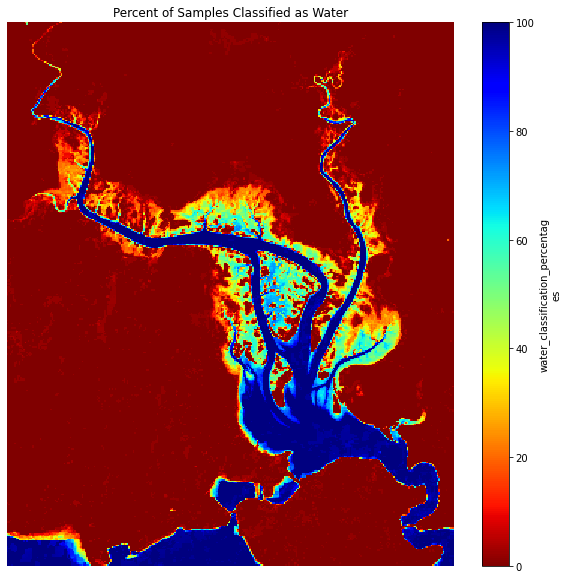

In [13]:
# This is where the WOFS time series product is generated. 
# Areas of RED have experienced little or no water over the time series
# Areas of BLUE have experience significant or constant water over the time series

water_classification_percentages.plot(cmap=jet_r, figsize=(10,10))
plt.title("Percent of Samples Classified as Water")
plt.axis('off')
plt.show()